## ETL

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
homicidios = pd.read_excel("../Datasets/homicidios.xlsx",sheet_name=None)
lesiones = pd.read_excel("../Datasets/lesiones.xlsx")

In [7]:
print(homicidios["HECHOS"].describe())

       N_VICTIMAS                          FECHA         AAAA          MM  \
count  696.000000                            696   696.000000  696.000000   
mean     1.030172  2018-09-14 05:12:24.827586048  2018.188218    6.692529   
min      1.000000            2016-01-01 00:00:00  2016.000000    1.000000   
25%      1.000000            2017-04-02 12:00:00  2017.000000    4.000000   
50%      1.000000            2018-07-12 12:00:00  2018.000000    7.000000   
75%      1.000000            2020-01-04 06:00:00  2020.000000   10.000000   
max      3.000000            2021-12-30 00:00:00  2021.000000   12.000000   
std      0.179393                            NaN     1.683754    3.571309   

               DD        Altura      COMUNA  
count  696.000000    129.000000  696.000000  
mean    15.936782   3336.635659    7.425287  
min      1.000000     30.000000    0.000000  
25%      9.000000   1359.000000    4.000000  
50%     16.000000   2551.000000    8.000000  
75%     23.000000   4500.00000

* Dando un vistazo, por el momento lo unico que pude ver basandome en la organizacion de Buenos Aires Argentina (ARG), no existe ninguna comuna numero cero (0) por lo que el valor minimo en la columna 'COMUNA' deberia ser 1.

In [11]:
comuna_cero = homicidios["HECHOS"][homicidios["HECHOS"]['COMUNA']==0]
print(comuna_cero)

            ID  N_VICTIMAS      FECHA  AAAA  MM  DD      HORA  HH  \
119  2016-0151           1 2016-11-18  2016  11  18  20:35:00  20   
139  2016-0174           1 2016-12-27  2016  12  27  00:00:00   0   

          LUGAR_DEL_HECHO TIPO_DE_CALLE  ... Altura  Cruce  \
119                    SD         CALLE  ...    NaN    NaN   
139  AUTOPISTA 25 DE MAYO     AUTOPISTA  ...    NaN    NaN   

    Dirección Normalizada COMUNA    XY (CABA) pos x pos y PARTICIPANTES  \
119                   NaN      0  Point (. .)     .     .     PEATON-SD   
139  AUTOPISTA 25 DE MAYO      0  Point (. .)     .     .         SD-SD   

    VICTIMA ACUSADO  
119  PEATON      SD  
139      SD      SD  

[2 rows x 21 columns]


* Ahora bien, ya sabemos que las filas 119 y 139 contienen datos erroneos o faltantes necesarios para el analisis, por lo que no las tendremos en cuenta en adelante.

In [12]:
homicidios["HECHOS"] = homicidios["HECHOS"].drop(comuna_cero.index)

* Analisamos si existen duplicados en la columna ID.

In [19]:
duplicados_id = homicidios['HECHOS']['ID'].duplicated(keep=False)


filas_duplicadas_id = homicidios['HECHOS'][duplicados_id]
print(filas_duplicadas_id)

Empty DataFrame
Columns: [ID, N_VICTIMAS, FECHA, AAAA, MM, DD, HORA, HH, LUGAR_DEL_HECHO, TIPO_DE_CALLE, Calle, Altura, Cruce, Dirección Normalizada, COMUNA, XY (CABA), pos x, pos y, PARTICIPANTES, VICTIMA, ACUSADO]
Index: []

[0 rows x 21 columns]


* No hay duplicados asi que procedemos a analizar los datos.

In [18]:
print(homicidios["HECHOS"].info())

<class 'pandas.core.frame.DataFrame'>
Index: 694 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     694 non-null    object        
 1   N_VICTIMAS             694 non-null    int64         
 2   FECHA                  694 non-null    datetime64[ns]
 3   AAAA                   694 non-null    int64         
 4   MM                     694 non-null    int64         
 5   DD                     694 non-null    int64         
 6   HORA                   694 non-null    object        
 7   HH                     694 non-null    object        
 8   LUGAR_DEL_HECHO        694 non-null    object        
 9   TIPO_DE_CALLE          694 non-null    object        
 10  Calle                  694 non-null    object        
 11  Altura                 129 non-null    float64       
 12  Cruce                  525 non-null    object        
 13  Dirección 

* Analizando el resultado respecto a los datos nulos y revisando el diccionario de los hechos podemos entender que para el caso no es indispensable la columna 'ALTURA' en los casos donde se encuentra un cruce, y de esta misma manera cuando hay valores faltantes en la columna 'CRUCE' corresponde a que es a una altura especifica.

### Graficos

* Desarrollo un grafico de barras para analizar el comportamiento de los datos y hallar posibles errores.

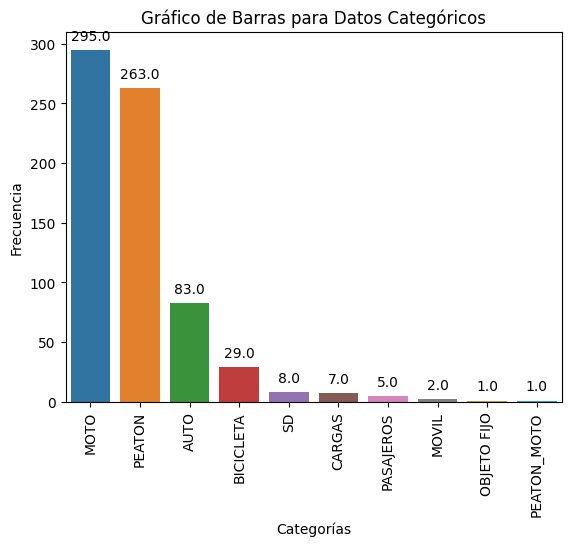

In [29]:
# Suponiendo que 'columna' es la columna que deseas visualizar
conteo_categorias = homicidios['HECHOS']['VICTIMA'].value_counts()
# Ordena las categorías por frecuencia en orden descendente
conteo_categorias = conteo_categorias.sort_values(ascending=False)
# Crea el gráfico de barras
sns.countplot(data=homicidios['HECHOS'], x=homicidios['HECHOS']['VICTIMA'], order=conteo_categorias.index)
plt.xticks(rotation=90)
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras para Datos Categóricos')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()
plt.show()

* Encontramos en el grafico que hay valores erroneos, ya que analizando el diccionario 'SD' me dice que no tengo datos acerca de la victima y 'OBJETO FIJO', 'PEATON MOTO' no estan definidos como victimas, por lo que procedemos a buscar estos casos en la hoja de 'VICTIMAS' para evaluar si se pueden encontrar los datos.

In [30]:
# Filtro filas por hechos
filas_victimas_especificas = homicidios['HECHOS'][(homicidios['HECHOS']['VICTIMA'] == 'PEATON_MOTO') | (homicidios['HECHOS']['VICTIMA'] == 'OBJETO FIJO')]
# Hago una fila de los ID filtrados
lista_ids = filas_victimas_especificas['ID'].tolist()
# Imprimo resultados
print(lista_ids)

['2017-0108', '2020-0063']


* Estos ID son los que debo evaluar.

In [31]:
# Transformo la columna de ID en lista para mejor manejo
conjunto_ids = set(lista_ids)
# Filtro la columna "VICTIMA" 
filas_filtradas = homicidios['VICTIMAS'][homicidios['VICTIMAS']['ID_hecho'].isin(conjunto_ids)]
# Imprimo resultado
print(filas_filtradas)

      ID_hecho      FECHA  AAAA  MM  DD                   ROL VICTIMA  \
237  2017-0108 2017-09-02  2017   9   2  PASAJERO_ACOMPAÑANTE    AUTO   
238  2017-0108 2017-09-02  2017   9   2  PASAJERO_ACOMPAÑANTE    AUTO   
602  2020-0063 2020-12-05  2020  12   5                PEATON  PEATON   
603  2020-0063 2020-12-05  2020  12   5  PASAJERO_ACOMPAÑANTE    MOTO   

          SEXO EDAD  FECHA_FALLECIMIENTO  
237  MASCULINO   17  2017-09-02 00:00:00  
238  MASCULINO   10  2017-09-02 00:00:00  
602  MASCULINO   38  2020-12-05 00:00:00  
603  MASCULINO   21  2020-12-05 00:00:00  


* Aca podemos ver que el error radica en la columna 'VICTIMA' ya que para los dos ID se debe reemplazar valores acorde a la definicion del diccionario.

In [32]:
fila_a_modificar = homicidios['HECHOS'][homicidios['HECHOS']['ID'] == '2017-0108']

# Hago el respectivo ajuste.
homicidios['HECHOS'].loc[fila_a_modificar.index, 'VICTIMA'] = 'AUTO'
homicidios['HECHOS'].loc[fila_a_modificar.index, 'ACUSADO'] = 'OBJETO FIJO'

Guardo los Datasets para poder trabajarlos mas adelante.

In [33]:
homicidios['HECHOS'].to_excel('../Datasets/homicidios_HECHOS.xlsx', index=False)
homicidios['VICTIMAS'].to_excel('../Datasets/homicidios_VICTIMAS.xlsx', index=False)